In [1]:
from __future__ import annotations

import warnings
from dataclasses import dataclass
from typing import Callable, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_california_housing, fetch_openml, load_breast_cancer
from sklearn.ensemble import (
    AdaBoostClassifier,
    AdaBoostRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

try:
    from xgboost import XGBClassifier, XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBClassifier = XGBRegressor = None
    XGBOOST_AVAILABLE = False
    print("xgboost is not installed")

try:
    from lightgbm import LGBMClassifier, LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LGBMClassifier = LGBMRegressor = None
    LIGHTGBM_AVAILABLE = False
    print("lightgbm is not installed")

assert XGBOOST_AVAILABLE and LIGHTGBM_AVAILABLE, "Please install both `xgboost` and `lightgbm` for complete reproducibility."
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.display.float_format = "{:,.4f}".format
sns.set_theme(style="whitegrid")


/opt/anaconda3/envs/course/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass
class DatasetConfig:
    key: str
    pretty_name: str
    loader: Callable[[], Tuple[pd.DataFrame, pd.Series]]
    task: str = "classification"
    notes: str = ""

def _replace_question_marks(frame: pd.DataFrame) -> pd.DataFrame:
    return frame.replace("?", np.nan)

def load_adult_income() -> Tuple[pd.DataFrame, pd.Series]:
    dataset = fetch_openml(name="adult", version=2, as_frame=True)
    X = _replace_question_marks(dataset.data.copy())
    y = dataset.target.str.strip()
    return X, y

def load_heart_disease() -> Tuple[pd.DataFrame, pd.Series]:
    dataset = fetch_openml(name="heart-disease", version=1, as_frame=True)
    frame = dataset.frame.copy()
    target_col = dataset.details.get("default_target_attribute") if dataset.details else None
    if not target_col:
        target_candidates = [col for col in frame.columns if col.lower() in {"target", "class", "label"}]
        target_col = target_candidates[0] if target_candidates else frame.columns[-1]
    y = frame.pop(target_col)
    X = _replace_question_marks(frame)
    y = y.astype(str).str.lower()
    return X, y

def load_mushrooms() -> Tuple[pd.DataFrame, pd.Series]:
    dataset = fetch_openml(name="mushroom", version=1, as_frame=True)
    X = _replace_question_marks(dataset.data.copy())
    y = dataset.target.astype(str).str.lower()
    return X, y

def load_telco_churn() -> Tuple[pd.DataFrame, pd.Series]:
    dataset = fetch_openml(data_id=42178, as_frame=True)
    frame = dataset.frame.copy()
    frame.columns = [col.strip() for col in frame.columns]
    target = dataset.target
    if target is not None and not target.empty:
        y = target.astype(str).str.strip().str.lower()
        target_name = target.name
        if target_name in frame.columns:
            frame = frame.drop(columns=[target_name])
    else:
        target_candidates = [col for col in frame.columns if col.lower() in {"churn", "target", "class", "label"}]
        target_name = target_candidates[0] if target_candidates else frame.columns[-1]
        y = frame.pop(target_name).astype(str).str.strip().str.lower()
    if "customerID" in frame.columns:
        frame = frame.drop(columns=["customerID"])
    if "TotalCharges" in frame.columns:
        frame["TotalCharges"] = pd.to_numeric(frame["TotalCharges"].replace(" ", np.nan), errors="coerce")
    X = _replace_question_marks(frame)
    return X, y

def load_breast_cancer_dataset() -> Tuple[pd.DataFrame, pd.Series]:
    dataset = load_breast_cancer(as_frame=True)
    frame = dataset.frame.copy()
    y = frame.pop("target").map({0: "malignant", 1: "benign"})
    return frame, y

def load_credit_card_fraud(sample_size: int = 80000, random_state: int = 42) -> Tuple[pd.DataFrame, pd.Series]:
    dataset = fetch_openml(name="creditcard", version=1, as_frame=True)
    frame = dataset.frame.copy()
    frame["Class"] = frame["Class"].astype(int)
    if sample_size and sample_size < len(frame):
        frac = sample_size / len(frame)
        samples = []
        for label, group in frame.groupby("Class"):
            n = max(1, int(round(len(group) * frac)))
            samples.append(group.sample(n=min(len(group), n), random_state=random_state))
        frame = pd.concat(samples).sample(frac=1, random_state=random_state).reset_index(drop=True)
    y = frame.pop("Class").map({0: "legitimate", 1: "fraud"})
    return frame, y

def load_imdb_reviews(sample_size: int = 20000, random_state: int = 42) -> Tuple[pd.DataFrame, pd.Series]:
    dataset = load_dataset("imdb")
    train_df = dataset["train"].to_pandas()[["text", "label"]]
    test_df = dataset["test"].to_pandas()[["text", "label"]]
    frame = pd.concat([train_df, test_df], ignore_index=True)
    if sample_size and sample_size < len(frame):
        frame = frame.sample(n=sample_size, random_state=random_state)
    text = frame["text"].fillna("")
    letters_only = text.str.replace(r"[^A-Za-z]+", " ", regex=True).str.strip()
    word_counts = letters_only.str.split().str.len().fillna(0)
    char_lengths = text.str.len()
    avg_word_length = (letters_only.str.len() / word_counts.clip(lower=1)).fillna(0)
    upper_ratio = (
        text.str.replace(r"[^A-Z]", "", regex=True).str.len()
        / char_lengths.replace(0, np.nan)
    ).fillna(0)
    features = pd.DataFrame({
        "char_length": char_lengths,
        "word_count": word_counts,
        "avg_word_length": avg_word_length,
        "exclamation_count": text.str.count("!"),
        "question_count": text.str.count("\?"),
        "upper_ratio": upper_ratio,
    })
    y = frame["label"].map({0: "negative", 1: "positive"})
    return features.reset_index(drop=True), y.reset_index(drop=True)

DATASETS = [
    DatasetConfig(key="adult", pretty_name="Adult Income", loader=load_adult_income, notes="Predict >50K annual income."),
    DatasetConfig(key="heart", pretty_name="Heart Disease", loader=load_heart_disease, notes="Binary heart disease diagnosis."),
    DatasetConfig(key="mushroom", pretty_name="Mushroom Classification", loader=load_mushrooms, notes="Edible vs poisonous."),
    DatasetConfig(key="telco", pretty_name="Telco Customer Churn", loader=load_telco_churn, notes="Telecom churn prediction."),
    DatasetConfig(key="breast_cancer", pretty_name="Breast Cancer", loader=load_breast_cancer_dataset, notes="Wisconsin diagnostic dataset."),
    DatasetConfig(key="credit", pretty_name="Credit Card Fraud", loader=load_credit_card_fraud, notes="Highly imbalanced fraud detection."),
    DatasetConfig(key="imdb", pretty_name="IMDB Movie Reviews", loader=load_imdb_reviews, notes="Sentiment features engineered from reviews."),
]

print(f"Configured datasets: {[cfg.pretty_name for cfg in DATASETS]}")


Configured datasets: ['Adult Income', 'Heart Disease', 'Mushroom Classification', 'Telco Customer Churn', 'Breast Cancer', 'Credit Card Fraud', 'IMDB Movie Reviews']


<>:98: SyntaxWarning: "\?" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\?"? A raw string is also an option.
<>:98: SyntaxWarning: "\?" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\?"? A raw string is also an option.
/var/folders/cm/9lmn6ll511g1zw7h85lq56n40000gn/T/ipykernel_81518/1182588621.py:98: SyntaxWarning: "\?" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\?"? A raw string is also an option.
  "question_count": text.str.count("\?"),


In [3]:
BOOSTING_ALGOS = ["adaboost", "gbm", "xgboost", "lightgbm"]

def _build_model(task: str, algorithm: str, random_state: int):
    algorithm = algorithm.lower()
    if algorithm == "adaboost":
        if task == "classification":
            return AdaBoostClassifier(n_estimators=400, learning_rate=0.5, random_state=random_state)
        return AdaBoostRegressor(n_estimators=500, learning_rate=0.3, loss="square", random_state=random_state)
    if algorithm == "gbm":
        if task == "classification":
            return GradientBoostingClassifier(random_state=random_state)
        return GradientBoostingRegressor(random_state=random_state)
    if algorithm == "xgboost":
        if not XGBOOST_AVAILABLE:
            raise ImportError("Install the `xgboost` package to run XGBoost models.")
        if task == "classification":
            return XGBClassifier(
                n_estimators=600,
                learning_rate=0.05,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="auc",
                tree_method="hist",
                random_state=random_state,
                n_jobs=-1,
            )
        return XGBRegressor(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            objective="reg:squarederror",
            random_state=random_state,
            n_jobs=-1,
        )
    if algorithm == "lightgbm":
        if not LIGHTGBM_AVAILABLE:
            raise ImportError("Install the `lightgbm` package to run LightGBM models.")
        if task == "classification":
            return LGBMClassifier(
                n_estimators=600,
                learning_rate=0.05,
                subsample=0.9,
                colsample_bytree=0.9,
                objective="binary",
                random_state=random_state,
                n_jobs=-1,
            )
        return LGBMRegressor(
            n_estimators=800,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="regression_l2",
            random_state=random_state,
            n_jobs=-1,
        )
    raise ValueError(f"Unsupported algorithm: {algorithm}")

def build_model_pipeline(
    X: pd.DataFrame,
    config: DatasetConfig,
    task: str,
    algorithm: str,
    random_state: int = 42,
) -> Pipeline:
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = [col for col in X.columns if col not in numeric_features]

    transformers = []
    if numeric_features:
        numeric_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
        transformers.append(("num", numeric_transformer, numeric_features))

    if categorical_features:
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ]
        )
        transformers.append(("cat", categorical_transformer, categorical_features))

    preprocessor = ColumnTransformer(transformers, remainder="drop")
    model = _build_model(task, algorithm, random_state)
    return Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

def _scoring(task: str) -> Dict[str, str]:
    if task == "classification":
        return {
            "accuracy": "accuracy",
            "balanced_accuracy": "balanced_accuracy",
            "f1_weighted": "f1_weighted",
            "roc_auc": "roc_auc",
        }
    return {
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2",
    }

def _predict_proba(model, X):
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if proba.ndim == 2 and proba.shape[1] > 1:
            return proba[:, 1]
        return proba.ravel()
    if hasattr(model, "decision_function"):
        decision = model.decision_function(X)
        decision = np.asarray(decision)
        if decision.ndim == 1:
            decision = (decision - decision.min()) / (decision.max() - decision.min() + 1e-8)
            return decision
    return None

def _compute_metrics(
    task: str,
    y_true: pd.Series,
    y_pred: np.ndarray,
    y_proba: np.ndarray | None = None,
    encoder: LabelEncoder | None = None,
) -> Tuple[Dict[str, float], str]:
    if task == "classification":
        metrics = {
            "accuracy": accuracy_score(y_true, y_pred),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
            "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        }
        if y_proba is not None:
            metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
        else:
            metrics["roc_auc"] = np.nan
        labels_true = encoder.inverse_transform(y_true) if encoder is not None else y_true
        labels_pred = encoder.inverse_transform(y_pred) if encoder is not None else y_pred
        report = classification_report(labels_true, labels_pred)
    else:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        metrics = {"rmse": rmse, "mae": mae, "r2": r2}
        report = f"RMSE: {rmse:.4f} MAE: {mae:.4f} R²: {r2:.4f}"
    return metrics, report

def evaluate_dataset(
    config: DatasetConfig,
    algorithm: str,
    test_size: float = 0.2,
    cv: int = 5,
    random_state: int = 42,
) -> Tuple[Dict[str, float], str]:
    X, y = config.loader()
    if config.task == "classification":
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        encoder = LabelEncoder()
        y_encoded = pd.Series(
            encoder.fit_transform(y),
            index=y.index,
            name=y.name or "target",
        )
    else:
        encoder = None
        y_encoded = y

    stratify = y_encoded if config.task == "classification" else None
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y_encoded,
        test_size=test_size,
        stratify=stratify,
        random_state=random_state,
    )

    base_pipeline = build_model_pipeline(X, config, config.task, algorithm, random_state=random_state)
    pipeline = clone(base_pipeline)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = _predict_proba(pipeline, X_test)
    test_metrics, detailed_report = _compute_metrics(config.task, y_test, y_pred, y_proba, encoder)

    cv_results = cross_validate(
        base_pipeline,
        X,
        y_encoded,
        cv=cv,
        scoring=_scoring(config.task),
        n_jobs=-1,
    )
    cv_summary = {}
    for key, values in cv_results.items():
        if not key.startswith("test_"):
            continue
        metric = key.replace("test_", "")
        scores = np.asarray(values)
        if config.task == "regression" and metric in {"rmse", "mae"}:
            scores = -scores
        cv_summary[f"{metric}_mean"] = scores.mean()
        cv_summary[f"{metric}_std"] = scores.std()

    result = {
        "dataset": config.pretty_name,
        "task": config.task,
        "model": algorithm,
        "n_samples": len(X),
        "n_features": X.shape[1],
        "notes": config.notes,
    }
    result.update({f"test_{k}": v for k, v in test_metrics.items()})
    result.update({f"cv_{k}": v for k, v in cv_summary.items()})
    return result, detailed_report


===== Evaluating Adult Income | ADABOOST =====
===== Evaluating Heart Disease | ADABOOST =====
===== Evaluating Mushroom Classification | ADABOOST =====
===== Evaluating Telco Customer Churn | ADABOOST =====
===== Evaluating Breast Cancer | ADABOOST =====
===== Evaluating Credit Card Fraud | ADABOOST =====
===== Evaluating IMDB Movie Reviews | ADABOOST =====
===== Evaluating Adult Income | GBM =====
===== Evaluating Heart Disease | GBM =====
===== Evaluating Mushroom Classification | GBM =====
===== Evaluating Telco Customer Churn | GBM =====
===== Evaluating Breast Cancer | GBM =====
===== Evaluating Credit Card Fraud | GBM =====
===== Evaluating IMDB Movie Reviews | GBM =====
===== Evaluating Adult Income | XGBOOST =====
===== Evaluating Heart Disease | XGBOOST =====
===== Evaluating Mushroom Classification | XGBOOST =====
===== Evaluating Telco Customer Churn | XGBOOST =====
===== Evaluating Breast Cancer | XGBOOST =====
===== Evaluating Credit Card Fraud | XGBOOST =====
===== Evalu

,dataset,task,model,n_samples,n_features,notes,test_accuracy,test_balanced_accuracy,test_f1_weighted,test_roc_auc,cv_accuracy_mean,cv_accuracy_std,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_weighted_mean,cv_f1_weighted_std,cv_roc_auc_mean,cv_roc_auc_std
0,Adult Income,classification,adaboost,48842,14,Predict >50K annual income.,0.8578,0.7562,0.8491,0.9115,0.8569,0.0025,0.7604,0.0057,0.8494,0.0030,0.9121,0.0030
1,Heart Disease,classification,adaboost,303,13,Binary heart disease diagnosis.,0.8197,0.8144,0.8185,0.8972,0.8017,0.0328,0.7967,0.0377,0.8000,0.0350,0.8998,0.0323
2,Mushroom Classification,classification,adaboost,8124,22,Edible vs poisonous.,1.0000,1.0000,1.0000,1.0000,0.9471,0.0744,0.9478,0.0720,0.9458,0.0766,0.9992,0.0017
3,Telco Customer Churn,classification,adaboost,7043,19,Telecom churn prediction.,0.8034,0.7185,0.7966,0.8424,0.8049,0.0056,0.7184,0.0088,0.7976,0.0058,0.8486,0.0113
4,Breast Cancer,classification,adaboost,569,30,Wisconsin diagnostic dataset.,0.9737,0.9643,0.9735,0.9871,0.9772,0.0089,0.9723,0.0098,0.9771,0.0090,0.9955,0.0048
5,Credit Card Fraud,classification,adaboost,80000,29,Highly imbalanced fraud detection.,0.9991,0.8926,0.9991,0.9871,0.9994,0.0001,0.8795,0.0462,0.9994,0.0001,0.9811,0.0105
6,IMDB Movie Reviews,classification,adaboost,20000,6,Sentiment features engineered from reviews.,0.5857,0.5863,0.5842,0.6240,0.5944,0.0062,0.5949,0.0062,0.5929,0.0065,0.6326,0.0054
7,Adult Income,classification,gbm,48842,14,Predict >50K annual income.,0.8676,0.7758,0.8608,0.9214,0.8670,0.0023,0.7766,0.0043,0.8604,0.0026,0.9212,0.0022
8,Heart Disease,classification,gbm,303,13,Binary heart disease diagnosis.,0.8197,0.8117,0.8172,0.8799,0.8150,0.0331,0.8102,0.0356,0.8135,0.0341,0.8855,0.0345
9,Mushroom Classification,classification,gbm,8124,22,Edible vs poisonous.,0.9988,0.9987,0.9988,1.0000,0.9515,0.0970,0.9532,0.0937,0.9489,0.1021,1.0000,0.0000


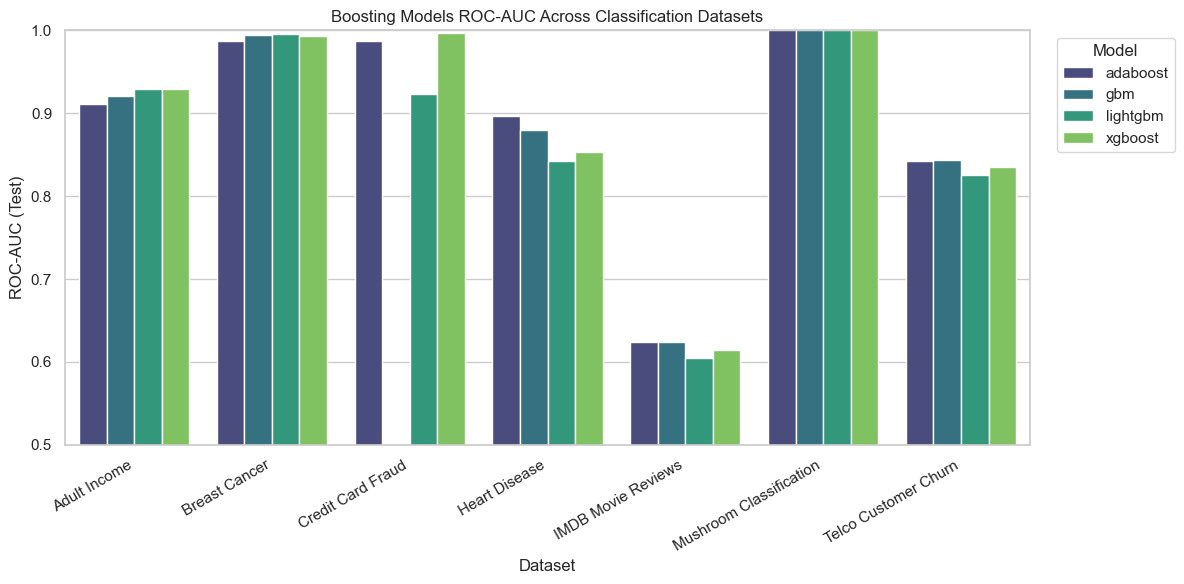

In [4]:
results = []
reports: Dict[str, str] = {}

for algorithm in BOOSTING_ALGOS:
    if algorithm == "xgboost" and not XGBOOST_AVAILABLE:
        print("Skipping XGBoost — package not installed.")
        continue
    if algorithm == "lightgbm" and not LIGHTGBM_AVAILABLE:
        print("Skipping LightGBM — package not installed.")
        continue
    for cfg in DATASETS:
        print(f"===== Evaluating {cfg.pretty_name} | {algorithm.upper()} =====")
        result, report = evaluate_dataset(cfg, algorithm)
        results.append(result)
        reports[f"{cfg.key}_{algorithm}"] = report

results_df = pd.DataFrame(results)
display(results_df)

auc_df = results_df[["dataset", "model", "test_roc_auc"]].dropna()
auc_df = auc_df.sort_values(["dataset", "model"])
plt.figure(figsize=(12, 6))
sns.barplot(data=auc_df, x="dataset", y="test_roc_auc", hue="model", palette="viridis")
plt.ylabel("ROC-AUC (Test)")
plt.xlabel("Dataset")
plt.xticks(rotation=30, ha="right")
plt.title("Boosting Models ROC-AUC Across Classification Datasets")
plt.ylim(0.5, 1.0)
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


for algorithm in BOOSTING_ALGOS:
    for cfg in DATASETS:
        key = f"{cfg.key}_{algorithm}"
        if key not in reports:
            continue
        print("" + "=" * 80)
        print(f"{cfg.pretty_name.upper()} | {algorithm.upper()}")
        print("-" * 80)
        print(reports[key])


## Modeling Utilities
The functions below assemble a shared preprocessing + model pipeline:
- numeric columns → median imputation + standard scaling
- categorical columns → most-frequent imputation + one-hot encoding (ignore unseen levels)
- model head → AdaBoost / GBM / XGBoost / LightGBM with tuned defaults per task

Evaluation uses a stratified train/test split (classification) plus 5-fold cross-validation for stabler estimates.

In [5]:
BOOSTING_ALGOS = ["adaboost", "gbm", "xgboost", "lightgbm"]

def _build_model(task: str, algorithm: str, random_state: int) -> object:
    algorithm = algorithm.lower()
    if algorithm == "adaboost":
        if task == "classification":
            return AdaBoostClassifier(n_estimators=400, learning_rate=0.5, random_state=random_state)
        return AdaBoostRegressor(
            n_estimators=500,
            learning_rate=0.3,
            loss="square",
            random_state=random_state,
        )
    if algorithm == "gbm":
        if task == "classification":
            return GradientBoostingClassifier(random_state=random_state)
        return GradientBoostingRegressor(random_state=random_state)
    if algorithm == "xgboost":
        if not XGBOOST_AVAILABLE:
            raise ImportError("Install the `xgboost` package to run XGBoost models.")
        if task == "classification":
            return XGBClassifier(
                n_estimators=600,
                learning_rate=0.05,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="logloss",
                tree_method="hist",
                random_state=random_state,
                n_jobs=-1,
            )
        return XGBRegressor(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            objective="reg:squarederror",
            random_state=random_state,
            n_jobs=-1,
        )
    if algorithm == "lightgbm":
        if not LIGHTGBM_AVAILABLE:
            raise ImportError("Install the `lightgbm` package to run LightGBM models.")
        if task == "classification":
            return LGBMClassifier(
                n_estimators=600,
                learning_rate=0.05,
                max_depth=-1,
                subsample=0.9,
                colsample_bytree=0.9,
                objective="binary",
                random_state=random_state,
                n_jobs=-1,
            )
        return LGBMRegressor(
            n_estimators=800,
            learning_rate=0.05,
            max_depth=-1,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="regression_l2",
            random_state=random_state,
            n_jobs=-1,
        )
    raise ValueError(f"Unsupported algorithm: {algorithm}")

def build_model_pipeline(
    X: pd.DataFrame,
    task: str,
    algorithm: str,
    random_state: int = 42,
) -> Pipeline:
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = [col for col in X.columns if col not in numeric_features]

    transformers = []
    if numeric_features:
        numeric_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
        transformers.append(("num", numeric_transformer, numeric_features))

    if categorical_features:
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ]
        )
        transformers.append(("cat", categorical_transformer, categorical_features))

    preprocessor = ColumnTransformer(transformers)
    model = _build_model(task, algorithm, random_state)
    return Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

def _scoring(task: str) -> Dict[str, str]:
    if task == "classification":
        return {
            "accuracy": "accuracy",
            "balanced_accuracy": "balanced_accuracy",
            "f1_weighted": "f1_weighted",
        }
    return {
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2",
    }

def _summarize_cv(cv_results: Dict[str, np.ndarray], task: str) -> Dict[str, float]:
    summary = {}
    for key, values in cv_results.items():
        if not key.startswith("test_"):
            continue
        metric = key.replace("test_", "")
        scores = np.asarray(values)
        if task == "regression" and metric in {"rmse", "mae"}:
            scores = -scores
        summary[f"{metric}_mean"] = scores.mean()
        summary[f"{metric}_std"] = scores.std()
    return summary

def _compute_metrics(task: str, y_true: pd.Series, y_pred: np.ndarray) -> Tuple[Dict[str, float], str]:
    if task == "classification":
        metrics = {
            "accuracy": accuracy_score(y_true, y_pred),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
            "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        }
        report = classification_report(y_true, y_pred)
    else:
        rmse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        metrics = {"rmse": rmse, "mae": mae, "r2": r2}
        report = f"RMSE: {rmse:.4f} MAE: {mae:.4f} R²: {r2:.4f}"
    return metrics, report

def evaluate_dataset(
    config: DatasetConfig,
    algorithm: str,
    test_size: float = 0.2,
    cv: int = 5,
    random_state: int = 42,
) -> Tuple[Dict[str, float], str]:
    X, y = config.loader()
    if config.task == "classification":
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        y = pd.Series(pd.Categorical(y).codes, index=y.index, name=y.name or "target")
    stratify = y if config.task == "classification" else None
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=stratify,
        random_state=random_state,
    )

    base_pipeline = build_model_pipeline(X, config.task, algorithm, random_state=random_state)
    pipeline = clone(base_pipeline)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_metrics, detailed_report = _compute_metrics(config.task, y_test, y_pred)

    cv_results = cross_validate(
        base_pipeline,
        X,
        y,
        cv=cv,
        scoring=_scoring(config.task),
        n_jobs=-1,
    )
    cv_summary = _summarize_cv(cv_results, config.task)

    result = {
        "dataset": config.pretty_name,
        "task": config.task,
        "model": algorithm,
        "n_samples": len(X),
        "n_features": X.shape[1],
        "notes": config.notes,
    }
    result.update({f"test_{k}": v for k, v in test_metrics.items()})
    result.update({f"cv_{k}": v for k, v in cv_summary.items()})

    return result, detailed_report

## Run Boosting Benchmark
The next cells iterate through every dataset–algorithm pair, collect hold-out and cross-validation metrics, and dump human-readable reports. Expect XGBoost/LightGBM + House Prices to take the longest due to high-dimensional one-hot encodings.

In [6]:
results = []
reports: Dict[str, str] = {}

for algorithm in BOOSTING_ALGOS:
    if algorithm == "xgboost" and not XGBOOST_AVAILABLE:
        print("Skipping XGBoost — package not installed.")
        continue
    if algorithm == "lightgbm" and not LIGHTGBM_AVAILABLE:
        print("Skipping LightGBM — package not installed.")
        continue
    for cfg in DATASETS:
        print(f"===== Evaluating {cfg.pretty_name} | {algorithm.upper()} =====")
        result, report = evaluate_dataset(cfg, algorithm)
        results.append(result)
        reports[f"{cfg.key}_{algorithm}"] = report

results_df = pd.DataFrame(results)

===== Evaluating Adult Income | ADABOOST =====
===== Evaluating Heart Disease | ADABOOST =====
===== Evaluating Mushroom Classification | ADABOOST =====
===== Evaluating Telco Customer Churn | ADABOOST =====
===== Evaluating Breast Cancer | ADABOOST =====
===== Evaluating Credit Card Fraud | ADABOOST =====
===== Evaluating IMDB Movie Reviews | ADABOOST =====
===== Evaluating Adult Income | GBM =====
===== Evaluating Heart Disease | GBM =====
===== Evaluating Mushroom Classification | GBM =====
===== Evaluating Telco Customer Churn | GBM =====
===== Evaluating Breast Cancer | GBM =====
===== Evaluating Credit Card Fraud | GBM =====
===== Evaluating IMDB Movie Reviews | GBM =====
===== Evaluating Adult Income | XGBOOST =====
===== Evaluating Heart Disease | XGBOOST =====
===== Evaluating Mushroom Classification | XGBOOST =====
===== Evaluating Telco Customer Churn | XGBOOST =====
===== Evaluating Breast Cancer | XGBOOST =====
===== Evaluating Credit Card Fraud | XGBOOST =====
===== Evalu

In [7]:
auc_df = results_df[["dataset", "model", "test_roc_auc"]].dropna()
auc_df = auc_df.sort_values(["dataset", "model"])
plt.figure(figsize=(12, 6))
sns.barplot(data=auc_df, x="dataset", y="test_roc_auc", hue="model", palette="viridis")
plt.ylabel("ROC-AUC (Test)")
plt.xlabel("Dataset")
plt.xticks(rotation=30, ha="right")
plt.title("Boosting Models ROC-AUC Across Classification Datasets")
plt.ylim(0.5, 1.0)
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


KeyError: "['test_roc_auc'] not in index"

In [ ]:
for algorithm in BOOSTING_ALGOS:
    for cfg in DATASETS:
        key = f"{cfg.key}_{algorithm}"
        if key not in reports:
            continue
        print("" + "=" * 80)
        print(f"{cfg.pretty_name.upper()} | {algorithm.upper()}")
        print("-" * 80)
        print(reports[key])